In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True

In [2]:
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg

from transition_matrix import get_transition_matrix
from scc_dags import get_scc_dag, get_attractor_states
from matrix_operations import compress_matrix
from basins import get_strong_basins, compare_strong_basins
from grouping import sd_grouping, null_grouping, random_grouping


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["strong_basins"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    stg = primes2stg(percolated_primes, update)
    scc_dag = get_scc_dag(stg)
    attractor_indexes = get_attractor_states(scc_dag, as_indexes=True)
    percolated_bnet = primes2bnet(percolated_primes)

    # Get strong_basins matrix for the transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_strong_basins = get_strong_basins(T, attractor_indexes, DEBUG=DEBUG)

    # Get strong_basins matrix for the sd grouped transition matrix
    sd_indexes = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tm = compress_matrix(T, sd_indexes, DEBUG=DEBUG)
    Tm_strong_basins = get_strong_basins(Tm, attractor_indexes, grouped=True, group_indexes=sd_indexes, DEBUG=DEBUG)

    # Get strong_basins matrix for the null grouped transition matrix
    null_indexes = null_grouping(percolated_bnet, DEBUG=DEBUG)
    T0 = compress_matrix(T, null_indexes, DEBUG=DEBUG)
    T0_strong_basins = get_strong_basins(T0, attractor_indexes, grouped=True, group_indexes=null_indexes, DEBUG=DEBUG)

    # Get comparison results
    data["strong_basins"]["Tm"] = compare_strong_basins(T_strong_basins, Tm_strong_basins, DEBUG=DEBUG)
    data["strong_basins"]["T0"] = compare_strong_basins(T_strong_basins, T0_strong_basins, DEBUG=DEBUG)

    # Get strong_basins matrix for the random matrix and get comparison results
    data["strong_basins"]["Tr_TP"] = []
    data["strong_basins"]["Tr_FP"] = []
    data["strong_basins"]["Tr_TN"] = []
    data["strong_basins"]["Tr_FN"] = []
    for i in range(num_runs):
        random_indexes = random_grouping(sd_indexes, null_indexes, seed=i, DEBUG=DEBUG)
        Tr = compress_matrix(T, random_indexes, DEBUG=DEBUG)
        Tr_strong_basins = get_strong_basins(Tr, attractor_indexes, grouped=True, group_indexes=random_indexes, DEBUG=DEBUG)

        strong_basins_random = compare_strong_basins(T_strong_basins, Tr_strong_basins, DEBUG=DEBUG)

        data["strong_basins"]["Tr_TP"].append(strong_basins_random[0])
        data["strong_basins"]["Tr_FP"].append(strong_basins_random[1])
        data["strong_basins"]["Tr_TN"].append(strong_basins_random[2])
        data["strong_basins"]["Tr_FN"].append(strong_basins_random[3])

    return data

In [3]:
import os

all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update="asynchronous", num_runs=1, DEBUG=True)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
import numpy as np

for bnet in all_data:
    if len(all_data[bnet]["strong_basins"]) == 0:
        continue
    print(bnet,
          all_data[bnet]["strong_basins"]["Tm"][0],
          all_data[bnet]["strong_basins"]["Tm"][1],
          all_data[bnet]["strong_basins"]["Tm"][2],
          all_data[bnet]["strong_basins"]["Tm"][3],

          np.mean(all_data[bnet]["strong_basins"]["Tr_TP"]),
          np.mean(all_data[bnet]["strong_basins"]["Tr_FP"]),
          np.mean(all_data[bnet]["strong_basins"]["Tr_TN"]),
          np.mean(all_data[bnet]["strong_basins"]["Tr_FN"]),

          all_data[bnet]["strong_basins"]["T0"][0],
          all_data[bnet]["strong_basins"]["T0"][1],
          all_data[bnet]["strong_basins"]["T0"][2],
          all_data[bnet]["strong_basins"]["T0"][3],

          )

n010_000.bnet 640 0 384 0 64.0 0.0 384.0 576.0 64 0 384 576
n010_001.bnet 10 0 36 18 6.0 0.0 36.0 22.0 6 0 36 22
n010_002.bnet 128 0 0 0 128.0 0.0 0.0 0.0 128 0 0 0
n010_003.bnet 1024 0 0 0 1024.0 0.0 0.0 0.0 1024 0 0 0
n010_004.bnet 124 0 326 62 4.0 0.0 326.0 182.0 4 0 326 182
n010_005.bnet 64 0 0 0 64.0 0.0 0.0 0.0 64 0 0 0
n010_006.bnet 96 0 892 36 2.0 0.0 892.0 130.0 2 0 892 130
n010_007.bnet 5 0 500 7 2.0 0.0 500.0 10.0 2 0 500 10
n010_008.bnet 130 0 112 14 34.0 0.0 112.0 110.0 34 0 112 110
n010_009.bnet 144 0 110 2 129.0 0.0 110.0 17.0 129 0 110 17
n010_011.bnet 260 0 232 20 35.0 0.0 232.0 245.0 35 0 232 245
n010_012.bnet 1024 0 0 0 1024.0 0.0 0.0 0.0 1024 0 0 0
n010_013.bnet 14 0 2 0 3.0 0.0 2.0 11.0 3 0 2 11
n010_014.bnet 8 0 0 0 8.0 0.0 0.0 0.0 8 0 0 0
n010_015.bnet 32 0 972 20 10.0 0.0 972.0 42.0 10 0 972 42
n010_016.bnet 266 0 246 0 3.0 0.0 246.0 263.0 3 0 246 263
n010_018.bnet 4 0 124 0 4.0 0.0 124.0 0.0 4 0 124 0
n010_019.bnet 128 0 0 0 128.0 0.0 0.0 0.0 128 0 0 0
n010_020

In [5]:
import matplotlib.pyplot as plt

def plot_precision_and_recall(TP, FP, TN, FN):

    # Lists to store precision and recall values
    precisions = []
    recalls = []

    # Calculate precision and recall for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate precision and recall
        if tp + fp != 0:
            precision = tp / (tp + fp)
            precisions.append(precision)
        if tp + fn != 0:
            recall = tp / (tp + fn)
            recalls.append(recall)
            
    # Create histograms of precision and recall
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(precisions, bins=10, color='blue', alpha=0.7)
    plt.title('Precision Histogram')
    plt.xlabel('Precision')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 2)
    plt.hist(recalls, bins=10, color='green', alpha=0.7)
    plt.title('Recall Histogram')
    plt.xlabel('Recall')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


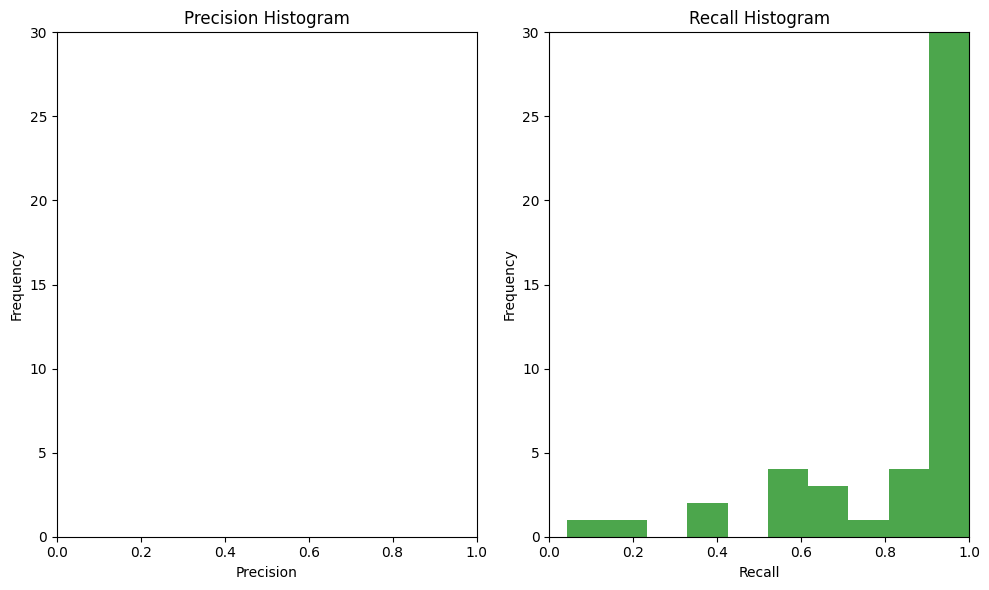

In [6]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["strong_basins"]) == 0:
        continue
    TP.append(all_data[bnet]["strong_basins"]["Tm"][0])
    FP.append(all_data[bnet]["strong_basins"]["Tm"][1])
    TN.append(all_data[bnet]["strong_basins"]["Tm"][2])
    FN.append(all_data[bnet]["strong_basins"]["Tm"][3])

print(np.arange(0, 1.1, 0.1))

plot_precision_and_recall(TP, FP, TN, FN)